# Phenome-Wide analysis on COPDgene data: R PIC-SURE API use-case

This notebook is an illustration example of how to use the R **PIC-SURE API** to select and query data from an HPDS-hosted database. It takes as use-case a simple PheWAS analysis. This notebook is intentionally straightforward, and explanation provided are only aimed at guiding through the PheWAS analysis pipeline. For a more step-by-step introduction to the R PIC-SURE API, see the `R_PICSURE-API_101_PheWAS_example.ipynb` Notebook.

**Before running this notebook, please be sure to get an user-specific security token. For more information on how to proceed, see the `HPDS_connection.ipynb` notebook**

## Environment set-up

### Environment pre-requisite
- R 3.5 or later

### Packages installation

In [1]:
list_packages <- c("jsonlite", 
                   "ggplot2",
                   "plyr",
                   "dplyr",
                   "tidyr",
                   "purrr",
                   "stringr",
                   "ggrepel",
                   "devtools")

for (package in list_packages){
     if(! package %in% installed.packages()){
         install.packages(package, dependencies = TRUE, 
                         character.only = TRUE)
     }
     library(package, character.only = TRUE)
}


Attaching package: ‘dplyr’


The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘purrr’


The following object is masked from ‘package:plyr’:

    compact


The following object is masked from ‘package:jsonlite’:

    flatten


Loading required package: usethis



#### Installing latest R PIC-SURE API libraries from github

In [2]:
devtools::install_github("hms-dbmi/pic-sure-r-client")
devtools::install_github("hms-dbmi/pic-sure-r-adapter-hpds")

Skipping install of 'picsure' from a github remote, the SHA1 (d62fec5d) has not changed since last install.
  Use `force = TRUE` to force installation

Skipping install of 'hpds' from a github remote, the SHA1 (3279fc36) has not changed since last install.
  Use `force = TRUE` to force installation



#### Loading user-defined functions

In [3]:
source("R_lib/utils.R")

## Connection to COPDgenes database

In [4]:
credentials_dic = jsonlite::read_json("dic_resources.json")

In [5]:
print(credentials_dic)

$csc
$csc$url
[1] "https://curesc.hms.harvard.edu/picsure/"

$csc$resource
[1] "37663534-6161-3830-6264-323031316539"

$csc$token_file
[1] "./tokens/csc.txt"


$copd
$copd$url
[1] "https://copdgene-dev.hms.harvard.edu/picsure/"

$copd$resource
[1] "b6ef7b1a-56f6-11e9-8958-0242c0a83007"

$copd$token_file
[1] "./tokens/copd.txt"


$DataSTAGE_dev
$DataSTAGE_dev$url
[1] "https://ec2-54-196-149-42.compute-1.amazonaws.com/picsure/"

$DataSTAGE_dev$resource
[1] "02e23f52-f354-4e8b-992c-d37c8b9ba140"

$DataSTAGE_dev$token_file
[1] "./tokens/DataSTAGE_dev.txt"




In [6]:
credentials = credentials_dic[["copd"]]

In [7]:
token <- TokenManager(credentials[["token_file"]])

In [8]:
myconnection <- picsure::connect(url = credentials[["url"]],
                                 token = token)

In [9]:
resource <- hpds::get.resource(myconnection,
                               resourceUUID = credentials[["resource"]])

## PheWAS analysis

In a nutshell, this PheWAS analysis follows those subsequent steps:
- Retrieving the variables dictionary, using the PIC-SURE API dedicated methods
- From the info provided by the dictionary, retrieving the data in an exploitable format through PIC-SURE API calls
- Data management
- Running univariate tests again every phenotypes variable
- Adjusting for multiple testing issue
- Plotting the results


This analysis is conducted using COPDGene Study data. The study overall goal is to detect underlying genetic factors to develop Chronic Obstructive Pulmonary Disease (COPD), and enrolled more than 10,000 individuals ([more information on COPDGene Study](http://www.copdgene.org)).

### 1. Retrieving variable dictionary from HPDS Database

In [10]:
all_variables <- hpds::find.in.dictionary(resource)

In [11]:
variablesDict <- hpds::extract.dataframe(all_variables)
variablesDict <- variablesDict[order(variablesDict["name"]),]

In [12]:
head(variablesDict[["name"]])

[1] "\\00 Affection status\\"                                                    
[2] "\\00 Consent groups\\"                                                      
[3] "\\01 Demographics\\Age at enrollment\\"                                     
[4] "\\01 Demographics\\Gender\\"                                                
[5] "\\01 Demographics\\Other\\De-identified site code\\"                        
[6] "\\01 Demographics\\Other\\Year of visit, to use for longitudinal analysis\\"

In [13]:
# Display the variables tree hierarchy from the variables name
multiIndex <- get_multiIndex(variablesDict)
head(multiIndex)

depth 1,depth 2,depth 3,depth 4,depth 5,name,simplified_name
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
00 Affection status,NA,NA,NA,NA,\00 Affection status\,00 Affection status
00 Consent groups,NA,NA,NA,NA,\00 Consent groups\,00 Consent groups
01 Demographics,Age at enrollment,NA,NA,NA,\01 Demographics\Age at enrollment\,Age at enrollment
01 Demographics,Gender,NA,NA,NA,\01 Demographics\Gender\,Gender
01 Demographics,Other,De-identified site code,NA,NA,\01 Demographics\Other\De-identified site code\,De-identified site code
01 Demographics,Other,"Year of visit, to use for longitudinal analysis",NA,NA,"\01 Demographics\Other\Year of visit, to use for longitudinal analysis\","Year of visit, to use for longitudinal analysis"


### 2. Selecting variables and retrieving data from HPDS

All phenotypical variables available will be included in the analysis, except for the variables pertaining to the "Sub-study ESP LungGO COPDGene" category (very small and specific subpopulation of the COPDGene Study).

In [14]:
mask_pheno = variablesDict["HpdsDataType"] == "phenotypes"
mask_substudy = multiIndex["depth 1"] != "Sub-study ESP LungGO COPDGene"
mask_vars = mask_pheno & mask_substudy
selected_vars = variablesDict[mask_vars, "name"]

In [15]:
my_query = hpds::new.query(resource = resource)
hpds::query.select.add(query = my_query, 
                      keys = selected_vars)
facts = hpds::query.run(query = my_query, result.type = "dataframe")

Warning message in if (has.key(key, self$data) == TRUE) {:
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (str_detect(norm_str, "rs[0-9]+$")) {:
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (str_detect(norm_str, "[0-9]+,[0-9\\.]+,.*")) {:
“la condition a une longueur > 1 et seul le premier élément est utilisé”


In [16]:
variablesDict["name"]

,name
,<chr>
261,\00 Affection status\
318,\00 Consent groups\
292,\01 Demographics\Age at enrollment\
337,\01 Demographics\Gender\
336,\01 Demographics\Other\De-identified site code\
335,"\01 Demographics\Other\Year of visit, to use for longitudinal analysis\"
74,\01 Demographics\Race\
81,\01 Demographics\Your ethnic background\
156,\02 Medical history\Exclusionary disease\Other primary disease so subject excluded from COPD disease analysis such as ILD or Bronchiectasis\


### 3. Data-management

Since variable names are not the same between the dictionary and the dataframe columns, a temporary workaround is needed: parsing variables names from variables dictionary to match actual column names. (issue arise from the fact the R data.frame column names cannot contain spaces).

In [17]:
variablesDict[["df_name"]] <- parsing_varNames(variablesDict[["name"]])
multiIndex[["df_name"]] <- variablesDict[["df_name"]]

In [18]:
checking_parsing(names(facts)[-1], variablesDict[mask_vars, "df_name"])

[1] "Every names match!"


#### Selecting variables regarding their types

One important step in a PheWAS is to get the distinction between categorical and numerical variables. This distinction is straightforward using the variables dictionary.

In [19]:
mask_categories <- variablesDict[, "categorical"] == TRUE
categorical_varnames <- variablesDict[mask_categories & mask_vars, "df_name"]
continuous_varnames <- variablesDict[!mask_categories & mask_vars, "df_name"]

### Selecting the dependent variable to study
Most of PheWAS use a genetic variant as the variable used to separate the population between cases and controls. However the population doesn't have to be dichotomized using a genetic variant, and any phenotypic variable could be used to run a PheWAS analysis (see for example [*Neuraz et al.*, 2013](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1003405)). 

Here we will use the **COPD status** as the case-control variable to dichotomize the population in our analysis (ie the dependent variable for which univariate association test will be run against).

In [20]:
dependent_var_name <- multiIndex[multiIndex[["simplified_name"]] == "00 Affection status",][["df_name"]]
categorical_varnames <- categorical_varnames[-which(categorical_varnames == dependent_var_name)]

In [21]:
table(facts[[dependent_var_name]])


                Case              Control Exclusionary Disease 
                3692                 4499                   64 
               Other 
                2116 

Then we subset our population regarding the relevant values for the COPD diagnosis variable (i.e. keeping "Case" and "Control" individuals, and discarding "Other", "Control, Exclusionary Disease", and null values).

In [22]:
mask_dependent_var_name = facts[[dependent_var_name]] %in% c("Case", "Control")

In [23]:
facts <- facts[mask_dependent_var_name,]

In [24]:
count_case_control <- table(facts[[dependent_var_name]])

In [25]:
sprintf("Control: %i individuals\nCase: %i individuals",
        count_case_control["Control"],
        count_case_control["Case"]) %>% cat()

Control: 4499 individuals
Case: 3692 individuals

### 4. Univariate statistical tests

Univariate logistic regression models will be runned using each phenotypical variable as the regressor, and Likelihood Ratio Test p-values for the model will be used to assess the significance of the association

In [26]:
## Unified univariate tests
### Significance of association tests are retrieved from the p-values of a Likelihood ratio test
anova_model <- function(data, dependent_var, independent_var) {
    model <- glm(as.formula(paste(dependent_var, "~ 1 +", independent_var)),
                 data = data,
                 family = binomial(link="logit"))
    model_reduced <- glm(as.formula(paste(dependent_var, "~ 1")),
                         data = data,
                         family = binomial(link="logit"))
    p_val <- anova(model, model_reduced, test =  "LRT")[2, "Pr(>Chi)"]
    return(p_val)    
}

In [27]:
independent_var_names = c(categorical_varnames, continuous_varnames)

In [28]:
pvalues_list = list()
error_list =  list()
warning_list = list()
for (independent_var_name in independent_var_names) {
    data <- na.omit(facts[,c(dependent_var_name, independent_var_name)])
    tryCatch({
                pvalues_list[[independent_var_name]] <- anova_model(data, dependent_var_name, independent_var_name)
#                error_list[[independent_var_name]] <- NA
 #               warning_list[[independent_var_name]] <- NA
    },
             error = function(e) {
                print(paste("error", independent_var_name))
                pvalues_list[[independent_var_name]] <- NA
                error_list[[independent_var_name]] <- e
                warning_list[[independent_var_name]] <- NA
             },
             warning = function(w) {
                print(paste("warning", independent_var_name))

                pvalues_list[[independent_var_name]] <- NA
                error_list[[independent_var_name]] <- NA
                warning_list[[independent_var_name]] <- w                 
             }
        )
}

[1] "error X.01.Demographics.Your.ethnic.background."
[1] "error X.02.Medical.history.Exclusionary.disease.Other.primary.disease.so.subject.excluded.from.COPD.disease.analysis.such.as.ILD.or.Bronchiectasis."
[1] "warning X.03.Clinical.data.CT.scan.Other.Final.GOLD.stage.post.QA."
[1] "warning X.03.Clinical.data.CT.scan.CT.measurements.CT.Slicer.HU.15th.percentile.Exp.Total.lung.CT.Slicer."
[1] "warning X.03.Clinical.data.CT.scan.CT.measurements.CT.VIDA.Wall.area.percent.sub.segmental.CT.VIDA."
[1] "warning X.03.Clinical.data.Spirometry.01.Prebronchodilator.Pulmonary.Function.Testing.FEF.25.75.pre.bronch."
[1] "warning X.03.Clinical.data.Spirometry.02.Postbronchodilator.Pulmonary.Function.Testing.FEF.25.75.post.bronch."
[1] "warning X.03.Clinical.data.Spirometry.02.Postbronchodilator.Pulmonary.Function.Testing.FEV1..percent..pred.post.bronch."
[1] "warning X.03.Clinical.data.Spirometry.02.Postbronchodilator.Pulmonary.Function.Testing.FEV1.FVC.post.bronch."


In [29]:
df_pvalues <- data.frame(
    "df_name" = names(pvalues_list),
    "pvalues" = simplify(unname(pvalues_list)), 
    stringsAsFactors = F
)

In [30]:
df_pvalues[["log_pvalues"]] <- -log10(df_pvalues$pvalues)

In [31]:
multiIndex_enhanced <- dplyr::left_join(multiIndex, df_pvalues, by="df_name")
variablesDict_enhanced <- dplyr::left_join(variablesDict, df_pvalues, by="df_name")

In [32]:
head(variablesDict_enhanced)

name,patientCount,min,categorical,observationCount,max,HpdsDataType,categoryValues,df_name,pvalues,log_pvalues
<chr>,<int>,<dbl>,<lgl>,<int>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>
\00 Affection status\,0,NA,TRUE,10371,NA,phenotypes,"Case,Control,Exclusionary Disease,Other",X.00.Affection.status.,NA,NA
\00 Consent groups\,0,NA,TRUE,10371,NA,phenotypes,"COPD_DS-CS-RD,COPD_HMB",X.00.Consent.groups.,1.455523e-09,8.836981
\01 Demographics\Age at enrollment\,0,39.9,FALSE,10371,85,phenotypes,NA,X.01.Demographics.Age.at.enrollment.,1.187027e-243,242.925539
\01 Demographics\Gender\,0,NA,TRUE,10371,NA,phenotypes,"Female,Male",X.01.Demographics.Gender.,3.208634e-03,2.493680
\01 Demographics\Other\De-identified site code\,0,NA,TRUE,10371,NA,phenotypes,"C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21",X.01.Demographics.Other.De.identified.site.code.,6.597524e-107,106.180619
"\01 Demographics\Other\Year of visit, to use for longitudinal analysis\",0,2007.0,FALSE,10371,2011,phenotypes,NA,X.01.Demographics.Other.Year.of.visit..to.use.for.longitudinal.analysis.,9.021772e-07,6.044708
\01 Demographics\Race\,0,NA,TRUE,10371,NA,phenotypes,"African American,Caucasian",X.01.Demographics.Race.,4.768608e-66,65.321608
\01 Demographics\Your ethnic background\,0,NA,TRUE,10371,NA,phenotypes,Not Hispanic or Latino,X.01.Demographics.Your.ethnic.background.,NA,NA
\02 Medical history\Exclusionary disease\Other primary disease so subject excluded from COPD disease analysis such as ILD or Bronchiectasis\,0,NA,TRUE,64,NA,phenotypes,"Bronchiectasis,ILD",X.02.Medical.history.Exclusionary.disease.Other.primary.disease.so.subject.excluded.from.COPD.disease.analysis.such.as.ILD.or.Bronchiectasis.,NA,NA


#### Univariate test p-values distribution

Warning message:
“Removed 25 rows containing non-finite values (stat_bin).”


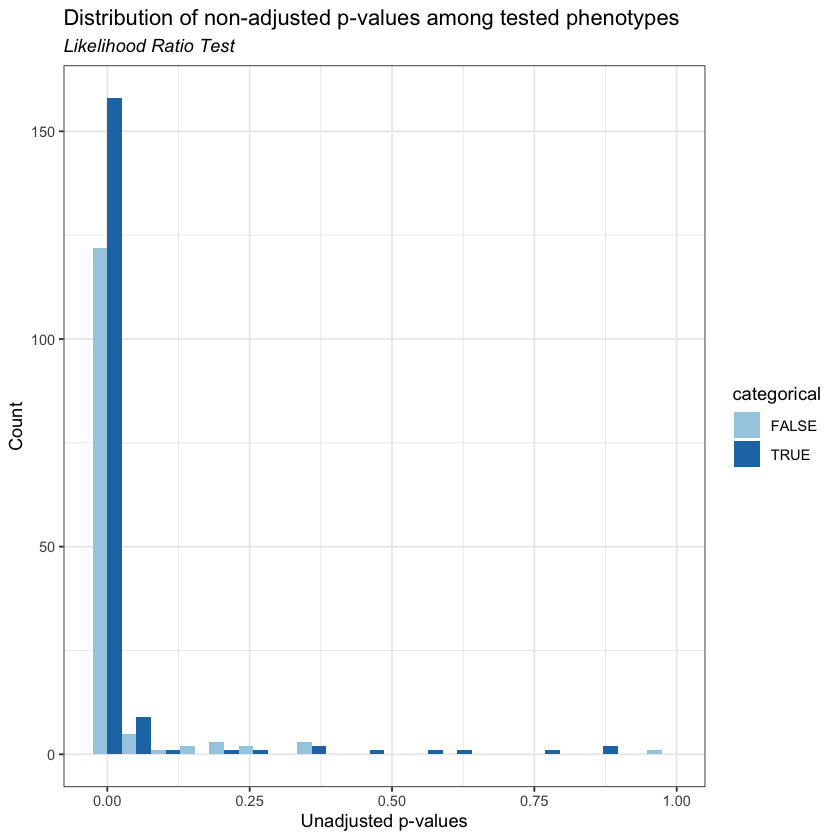

In [33]:
ggplot(aes_string(x = "pvalues", 
                 fill = "categorical"),
       data = variablesDict_enhanced) +
geom_histogram(bins=20, position = "dodge") +
scale_fill_brewer(palette='Paired') + 
labs(title = "Distribution of non-adjusted p-values among tested phenotypes ", 
    subtitle = expression(italic("Likelihood Ratio Test"))) +
xlab("Unadjusted p-values") +
ylab("Count") +
theme_bw()

## 5. Multiple hypotheses testing correction: Bonferroni Method

In order to handle the multiple comparison issue (increase in the probability to "discover" false statistical associations, because of the number of tests performed), we will use the Bonferroni correction method. Although many other multiple comparison exist, Bonferroni is the most straightforward to use, because it doesn't require assumptions about variables correlation. Other PheWAS analysis also use False Discovery Rate controlling procedures ([see reference](https://en.wikipedia.org/wiki/False_discovery_rate)).

In a nutshell, Bonferonni allows to calculate a corrected "statistical significant threshold" according to the number of test performed. Every p-value below this threshold will be deemed statistically significant.

In [74]:
variablesDict_enhanced$adj_pvalues <- p.adjust(variablesDict_enhanced$pvalues, method="bonferroni")

In [75]:
variablesDict_enhanced$log_adj_pvalues <- -log10(variablesDict_enhanced$adj_pvalues)

## 6. Result visualisations: Manhattan plot

Manhattan plot is the classical results representation of a PheWAS analysis. It plots every each tested phenotypical variables on the X-axis, against its *-log(pvalue)* on the Y-axis. The horizontal line represent the adjusted significance level threshold.

#### Preparing data

In [93]:
corrected_alpha <- 0.05/length(variablesDict_enhanced$pvalues) # Using Bonferonni method
adj_corrected_alpha <- -log10(corrected_alpha)

In [94]:
non_nan <- which(!is.na(variablesDict_enhanced$pvalues))
plot_df <- multiIndex_enhanced[non_nan, ]
plot_df$df_name <- as.factor(plot_df$df_name)
plot_df$log_pvalues <- round(plot_df$log_pvalues, 5)

plot_df = multiIndex[, c("df_name", "depth 2")] %>% 
plyr::rename(replace = c("depth 2" = "category")) %>%
right_join(plot_df, by="df_name")

plot_df <- plot_df[order(plot_df$category),]
plot_df$category <- factor(plot_df$category)
plot_df$name <- factor(plot_df$name, levels=plot_df$name[order(plot_df$category)])

Warning message:
“Column `df_name` joining character vector and factor, coercing into character vector”


In [95]:
# Suppressing Inf log(p-values)
plot_df <- plot_df[plot_df$log_pvalues != Inf,]

In [96]:
# Selecting 4 largest p-values, to be annotated in the Manatthan plot

largest_pvalues_indices <- order(plot_df[["log_pvalues"]], decreasing=T)[1:4]
plot_df$to_annotate <- "no"
plot_df[largest_pvalues_indices, "to_annotate"] <- "yes"

#### Plotting the data

In [97]:
options(repr.plot.width=12, repr.plot.height=8)

In [98]:
my_theme <- theme_bw() + 
theme(axis.title.y = element_text(face="italic", size=15),
      title = element_text(size=20),
      axis.title.x = element_text(size=15),
      axis.text.x = element_text(angle=35, hjust=1),
      legend.position = "none",
      panel.grid.major.x = element_blank()
      )


In [99]:
paired_colors <- c("navyblue", "lightskyblue")

Warning message:
“Removed 1 rows containing missing values (geom_point).”


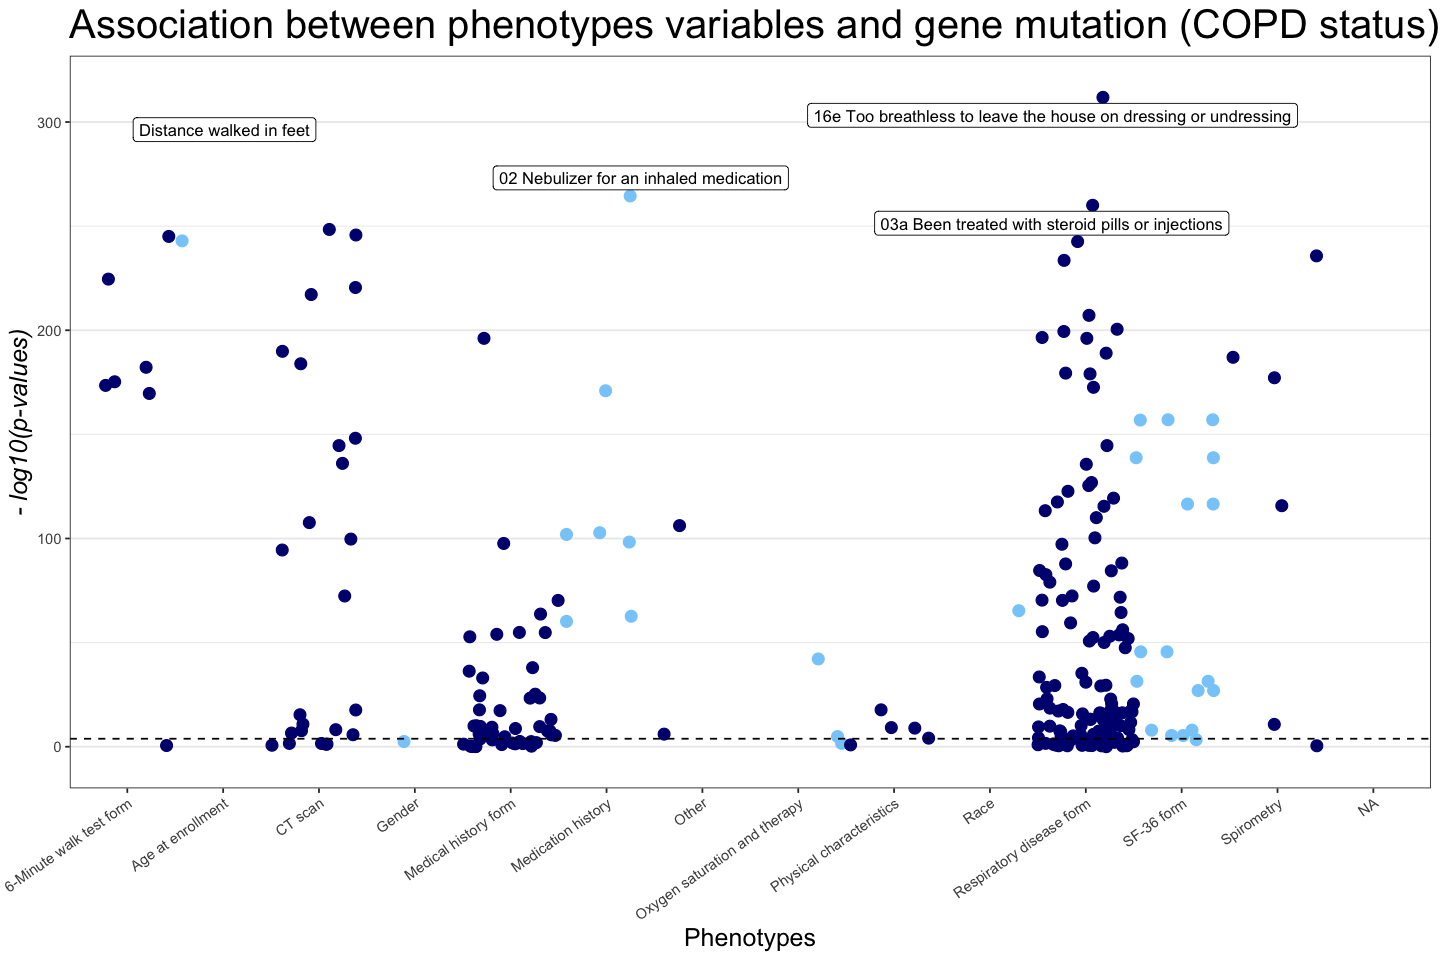

In [100]:
# Manatthan plot using geom_jitter --> more suitable when number of point per category is enough
ggplot(plot_df, aes(x=category, y=log_pvalues)) +
geom_jitter(alpha=1, aes_string(colour="category"), 
           width=0.5,
           size=3) +
geom_hline(yintercept=adj_corrected_alpha, linetype="dashed") +
scale_y_continuous(expand = c(0, 20) ) +
scale_color_manual(values = rep(paired_colors, times=20)) +
geom_label_repel( data=subset(plot_df, to_annotate=="yes"), aes(label=simplified_name), size=3.5) +
labs(title="Association between phenotypes variables and gene mutation (COPD status)", 
    x="Phenotypes", 
    y="- log10(p-values)",
    colour="Phenotypes categories") +
my_theme



Overall, it appears that most of the tested phenotypes covariates are above the adjusted threshold of significant association. However, it is not surprising at all, given the nature of our dependent variable: a lot of those variables are by nature tied directly to the COPD status. For instance, the 4 highest p-values (distance walked in feet, nebulizer for inhaled medication, too breathless to leave the house) are direct consequences of COPD disease.

This code can be used directly with any other variable present in the variable Dictionary. It only need to change the `dependent_var_name` value.